<a href="https://colab.research.google.com/github/haritvyas5/Robot-Arm/blob/main/Digital_Twin_Robot_Arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives

1. Learn how to use the Onshape REST API to access and manipulate assemblies.
2. Configure Python to communicate with Onshape using API keys.
3. Establish serial communication between Arduino and Python using **pyserial**.
4. Map analog sensor (potentiometer) values from Arduino to control mate motion in Onshape assemblies.
5. Develop an interactive system where hardware inputs drive CAD model animations.

## Background

Onshape provides a REST API for programmatically interacting with CAD models. By sending commands via Python, users can modify mate values, update assembly positions, and retrieve renderings.

Arduino microcontrollers can stream real-time sensor data (e.g., potentiometers), which Python can capture through serial communication. When combined, this allows physical hardware to directly manipulate digital CAD assemblies.

**Key Concepts:**

- **Part Studio vs. Assembly** – Parts are created in Part Studios and then combined in Assemblies using mates.
- **Mate Degrees of Freedom** – Revolute (rotation) or slider (translation) mates can be programmatically controlled.
- **Serial Communication** – Arduino sends sensor readings over USB for Python to process.
- **Mapping Functions** – Sensor values (0–1023) must be scaled into mate limits (e.g., 0–π radians).


# This is our OnShape Assembly

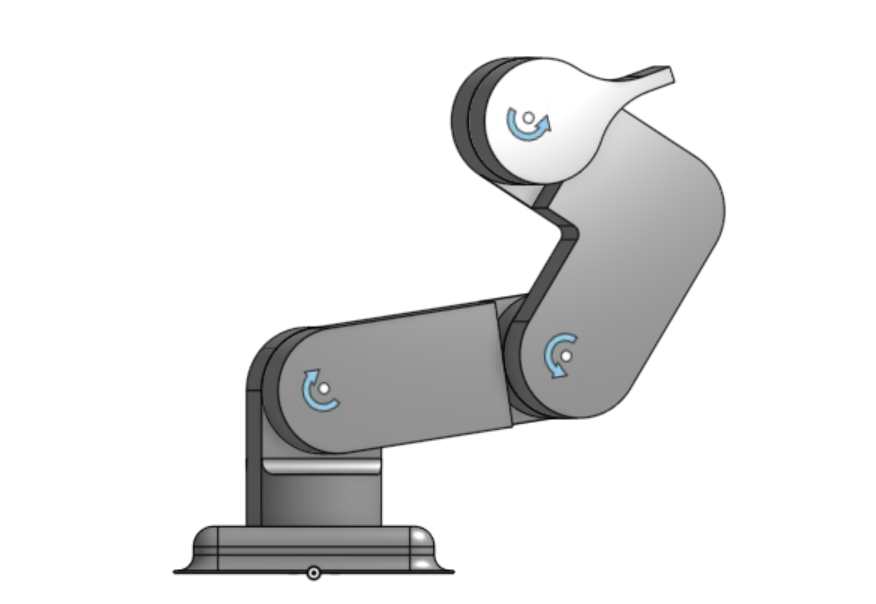

# Hello World Onshape API
This notebook shows how to use Onshape's REST API to create a GIF from an Onshape Assembly. You will use the API to make assemblies move, update the color and opacity of parts, and get a shaded image of the current view of the assembly. [Getting started video linked here](https://www.youtube.com/watch?v=5QCpUdMQbs0).

Befor you get started, you should know a little bit about Onshape and Python.

* Onshape
  * The difference between a Part Studio and an Assembly
  * How to make a part in a Part Studio
  * How to create a mate in an Assembly
* Python
  * What a function is
  * What a for loop is
  * What an array is

You can find a [full library of snippets in this notebook](https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Onshape_API_Snippets.ipynb) and you can check out [more example notebooks on this page](https://ptc-education.github.io/docs/solutions/onshapedx).

## Set up Onshape client
You will first need to go to the [Onshape Dev Portal](https://dev-portal.onshape.com/) and generate API keys. Select "no enterprise" if your document starts with "cad.onshape.com/...." and the first three options for key access. Then run the cell below to configure the Onshape API Client.

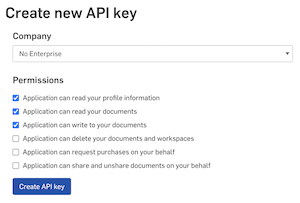

In [ ]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Copy/Paste Keys" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


## Define Mate Motion Functions

First run the cell below to see the values of the mates in your assembly. You can drag the parts in your assembly to move them around, then run the cell again to make sure the values are updated. **Note: this will not work if you have movable mates in a sub assembly**

In [ ]:
#@title Get Mates from Assembly
#@markdown Defines function `getAssemblyMates(url)`, which returns JSON of mates in an assembly

#@markdown Paste your URL below (must be an Assembly URL)
url = 'https://cad.onshape.com/documents/12a6db3669fb09d865ec8365/w/53e0976b5f2ca5298d8693ce/e/909ce9c9e5dea110a3cd8f2e' #@param {type:"string"}
showResponse = True #@param {type:"boolean"}

def getAssemblyMates(url):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  element = OnshapeElement(url)
  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

if showResponse:
  mates = getAssemblyMates(url)
  print(json.dumps(mates, indent=4, sort_keys=True))
else:
  pass

{
    "mateValues": [
        {
            "featureId": "MKSoHDUgSeJA3YH4F",
            "jsonType": "Revolute",
            "mateName": "Revolute 1",
            "rotationZ": 3.1224819235671046
        },
        {
            "featureId": "MUiEzkhmS0l+ti30K",
            "jsonType": "Revolute",
            "mateName": "Revolute 2",
            "rotationZ": -0.055421534056136146
        },
        {
            "featureId": "MacAGVzvSTpxXFNjJ",
            "jsonType": "Revolute",
            "mateName": "Revolute 4",
            "rotationZ": -0.789265479928261
        },
        {
            "featureId": "MuKu3sAM0/FtlL2Hl",
            "jsonType": "Revolute",
            "mateName": "Revolute 3",
            "rotationZ": 0.046985870803258487
        }
    ]
}


Now you can run this cell to update the mate values. Input the name of the mate you want to update and the position. **Note: this will only work for 1 degree of freedom mates (slider or revolute)**

In [ ]:
#@title Set Mates in Assembly
#@markdown Defines funciton `setMateByName(url,mateName,position)`, which updates the mate with the specified name to the specified position

#@markdown Paste your URL below (must be an Assembly URL)
url = 'https://cad.onshape.com/documents/12a6db3669fb09d865ec8365/w/53e0976b5f2ca5298d8693ce/e/909ce9c9e5dea110a3cd8f2e' #@param {type:"string"}
#@markdown Input the exact name of your mate feature from the assembly
mateName = "Revolute 2" #@param {type:"string"}
#@markdown Input the new position for the mate (revolute will be in radians, slider will be in meters)
position =  0.4#@param {type:"number"}
showResponse = False #@param {type:"boolean"}

def getAssemblyMates(url):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  element = OnshapeElement(url)
  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

def setMateByName(url,mateName,position):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/matevalues'
  mates = getAssemblyMates(url)
  element = OnshapeElement(url)


  for values in mates['mateValues']:
    if values['mateName'] == mateName:
      newMate = values

  if newMate['jsonType'] == 'Revolute':
    newMate['rotationZ'] = position
  elif newMate['jsonType'] == 'Slider':
    newMate['translationZ'] = position
  else:
    print('failed')

  method = 'POST'

  params = {}
  payload = {'mateValues':[newMate]}
  headers = {'Accept': 'application/vnd.onshape.v2+json',
              'Content-Type': 'application/vnd.onshape.v2+json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

newMates = setMateByName(url,mateName,position)
if showResponse:
  print(json.dumps(newMates, indent=4, sort_keys=True))
else:
  pass

# Estabilish a connection to a local jupyter runtime

In order to Control the Arduino that is connected to our local machine, we can use a jupyter notebook to connect to our local ports and connect them to our Colab file.


---

# Install Jupyter Notbook
Install JupyterLab with pip in your local terminal:

`pip install jupyterlab`

Note: If you install JupyterLab with conda or mamba, I recommend using the conda-forge channel.

Once installed, launch JupyterLab with:

`jupyter lab`

When you type this in a new notebook server is started normally, though you will need to set a flag to explicitly trust WebSocket connections from the Colab frontend.


```
jupyter lab --ServerApp.allow_origin="https://colab.research.google.com" --port=8888 --ServerApp.port_retries=0
```

    
Once the server has started, it will print a message with the initial backend URL used for authentication. Make a copy of this URL as you'll need to provide this for step 2 below.

# Connect to the local runtime

In Google Colab, click the "Connect" button and select "Connect to local runtime...". Enter the URL from the previous step in the dialog that appears and click the "Connect" button. After this, you should now be connected to your local runtime.


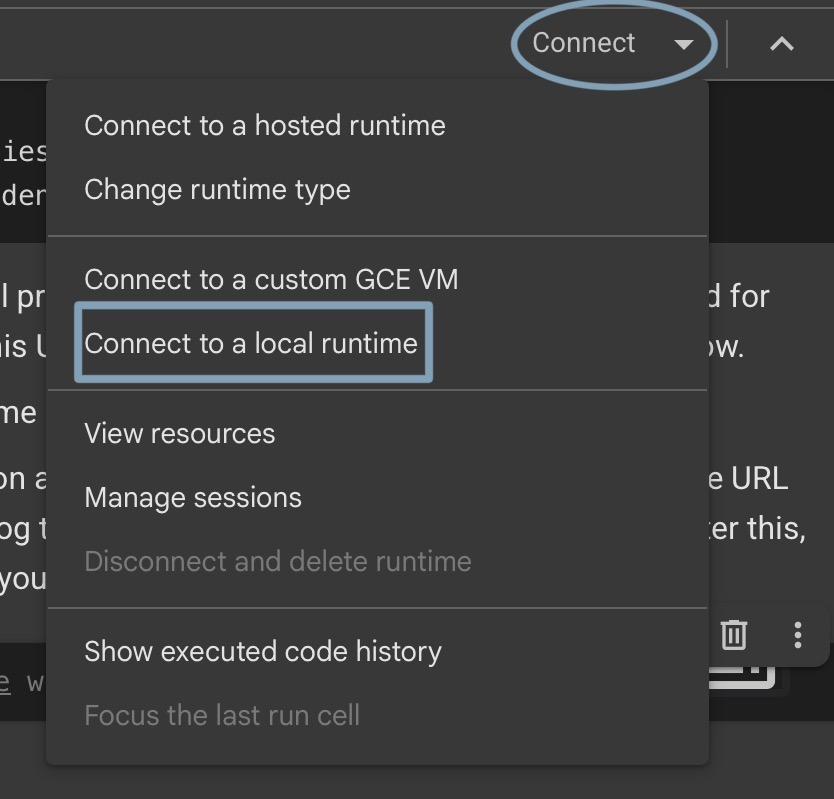

## Install pyserial

### Subtask:
Install the necessary library to communicate with the Arduino over the serial port.


---
Install the `pyserial` library using pip to enable communication with the Arduino over the serial port.



In [ ]:
!pip install pyserial


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Connect to arduino and read data

### Subtask:
Establish a connection to the Arduino and continuously read the comma-separated potentiometer values being sent over the serial port.


**Reasoning**:
Import the serial and time libraries and establish a serial connection to the Arduino, then continuously read and print data from the serial port.



---


# Note : Make sure to Change the values for your setup


In [ ]:
import serial
import time

# Define the serial port and baud rate
# You might need to change 'COM3' to the correct port for your system
# e.g., '/dev/ttyACM0' on Linux/macOS
serial_port = 'COM4' # Replace with your Arduino's serial port
baud_rate = 9600    # Replace with your Arduino's baud rate

try:
    # Create a serial connection object
    ser = serial.Serial(serial_port, baud_rate)
    print(f"Connected to serial port: {serial_port}")

    # Continuously read data from the serial port
    while True:
        if ser.in_waiting > 0:
            # Read a line of data
            line = ser.readline()
            # Decode the data from bytes to string
            decoded_line = line.decode('utf-8').strip()
            # Print the decoded data
            print(f"Received: {decoded_line}")

        # Add a small delay
        time.sleep(0.01)

except serial.SerialException as e:
    print(f"Error: Could not open serial port {serial_port}. Please check if the port is correct and the Arduino is connected.")
    print(f"Details: {e}")
except KeyboardInterrupt:
    print("Serial reading stopped by user.")
finally:
    # Close the serial connection if it was opened
    if 'ser' in locals() and ser.isOpen():
        ser.close()
        print("Serial port closed.")

Connected to serial port: COM4
Received: 0,210,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,210,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,210,306,1023
Received: 0,211,306,1023
Received: 0,210,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,211,306,1023
Received: 0,212,306

## Process sensor data

### Subtask:
Parse the incoming data from the Arduino to extract the individual potentiometer values.


**Reasoning**:
Modify the existing serial reading loop to parse the incoming comma-separated data, convert the values to integers, and store them, including error handling.



In [ ]:
import serial
import time
from math import isfinite

# ---- USER SETTINGS ----
serial_port = 'COM4'          # Make sure you're on a Local Runtime or use local Jupyter
baud_rate   = 9600            # Must match Arduino Serial.begin
onshape_url = 'https://cad.onshape.com/documents/12a6db3669fb09d865ec8365/w/53e0976b5f2ca5298d8693ce/e/909ce9c9e5dea110a3cd8f2e'

# Map each mate to a CSV index and (optionally) its own limits
# Index: which column in "v0,v1,v2,v3" this mate reads (0-based)
MATES = {
    "Revolute 1": {"index": 0, "mate_min": 0.0, "mate_max": 3.14},
    "Revolute 2": {"index": 1, "mate_min": 0.0, "mate_max": 3.14},
    "Revolute 3": {"index": 2, "mate_min": 0.0, "mate_max": 3.14},
    "Revolute 4": {"index": 3, "mate_min": 0.0, "mate_max": 3.14},
}

# If your sensor input range differs, change these:
SENSOR_MIN = 0
SENSOR_MAX = 1023

# Update throttling / change threshold (per mate)
MIN_MS_BETWEEN_UPDATES = 100     # don't update a given mate faster than 10 Hz
DELTA_TO_UPDATE        = 0.01    # only update if mapped value changes by >= 0.01

# Optional: a tiny delay after each successful Onshape update, to be extra gentle
POST_UPDATE_SLEEP_S    = 0.01

def map_sensor_to_mate(sensor_value, sensor_min=SENSOR_MIN, sensor_max=SENSOR_MAX,
                       mate_min=0.0, mate_max=3.14):
    sv = max(sensor_min, min(sensor_value, sensor_max))
    return mate_min + (sv - sensor_min) * (mate_max - mate_min) / (sensor_max - sensor_min)

# NOTE: You must have defined setMateByName(...) earlier. It should be synchronous and raise on error.
# def setMateByName(onshape_url, mate_name, value): ...

# ---- STATE (per-mate) ----
mate_state = {
    name: {"last_sent_value": None, "last_sent_time": 0.0}
    for name in MATES
}

try:
    ser = serial.Serial(serial_port, baud_rate, timeout=1)
    ser.reset_input_buffer()
    print(f"Connected to {serial_port} at {baud_rate}")

    while True:
        if ser.in_waiting > 0:
            try:
                line = ser.readline()
                if not line:
                    continue

                decoded = line.decode('utf-8', errors='ignore').strip()
                if not decoded:
                    continue

                # Expect e.g. "0,211,306,1023"
                parts = decoded.split(',')
                # Make sure we have enough columns for the highest index used
                if len(parts) <= max(cfg["index"] for cfg in MATES.values()):
                    # Not enough fields; skip
                    continue

                # Try parse all to ints once (invalids -> skip line)
                try:
                    values = [int(p.strip()) for p in parts]
                except ValueError:
                    # malformed line; ignore
                    continue

                # Process each mate independently
                now_ms = time.time() * 1000.0
                updates_made = 0

                for mate_name, cfg in MATES.items():
                    idx = cfg["index"]
                    raw = values[idx]

                    mapped = map_sensor_to_mate(
                        raw,
                        sensor_min=SENSOR_MIN, sensor_max=SENSOR_MAX,
                        mate_min=cfg.get("mate_min", 0.0),
                        mate_max=cfg.get("mate_max", 3.14),
                    )

                    if not isfinite(mapped):
                        continue

                    st = mate_state[mate_name]
                    should_send = (
                        st["last_sent_value"] is None or
                        abs(mapped - st["last_sent_value"]) >= DELTA_TO_UPDATE
                    ) and (now_ms - st["last_sent_time"]) >= MIN_MS_BETWEEN_UPDATES

                    if should_send:
                        try:
                            _ = setMateByName(onshape_url, mate_name, float(mapped))
                            st["last_sent_value"] = mapped
                            st["last_sent_time"]  = now_ms
                            updates_made += 1
                            print(f"OK [{mate_name}]: raw={raw} -> {mapped:.3f}")
                            if POST_UPDATE_SLEEP_S > 0:
                                time.sleep(POST_UPDATE_SLEEP_S)
                        except Exception as e:
                            print(f"Onshape update error ({mate_name}): {e}")
                            # brief backoff so we don't hammer during hiccups
                            time.sleep(0.2)

                # Optional: trace the whole CSV line occasionally
                # if updates_made == 0 and int(now_ms/1000) % 2 == 0:
                #     print(f"No updates: {decoded}")

            except Exception as e:
                # Catch-all for unexpected runtime issues in the loop
                # Keep running to remain robust to bad serial lines
                # print(f"Loop error: {e}")
                pass

        # Tiny sleep prevents CPU spin and keeps UI responsive
        time.sleep(0.01)

except serial.SerialException as e:
    print(f"Serial error opening {serial_port}: {e}")
except KeyboardInterrupt:
    print("Stopped by user.")
finally:
    try:
        if ser and ser.is_open:
            ser.close()
            print("Serial port closed.")
    except NameError:
        pass


Connected to COM4 at 9600
OK [Revolute 1]: raw=706 -> 2.167
OK [Revolute 2]: raw=211 -> 0.648
OK [Revolute 3]: raw=306 -> 0.939
OK [Revolute 4]: raw=1023 -> 3.140
OK [Revolute 2]: raw=21111 -> 3.140
OK [Revolute 2]: raw=211 -> 0.648
OK [Revolute 2]: raw=211706 -> 3.140
OK [Revolute 3]: raw=210 -> 0.645
OK [Revolute 4]: raw=305 -> 0.936
OK [Revolute 2]: raw=211 -> 0.648
OK [Revolute 3]: raw=306 -> 0.939
OK [Revolute 4]: raw=1023 -> 3.140
OK [Revolute 4]: raw=1007 -> 3.091
OK [Revolute 4]: raw=981 -> 3.011
OK [Revolute 4]: raw=965 -> 2.962
OK [Revolute 4]: raw=943 -> 2.894
OK [Revolute 4]: raw=911 -> 2.796
OK [Revolute 4]: raw=876 -> 2.689
OK [Revolute 4]: raw=855 -> 2.624
OK [Revolute 4]: raw=832 -> 2.554
OK [Revolute 4]: raw=811 -> 2.489
OK [Revolute 4]: raw=796 -> 2.443
OK [Revolute 4]: raw=788 -> 2.419
OK [Revolute 4]: raw=781 -> 2.397
OK [Revolute 4]: raw=775 -> 2.379
OK [Revolute 4]: raw=779 -> 2.391
OK [Revolute 4]: raw=783 -> 2.403
OK [Revolute 4]: raw=779 -> 2.391
OK [Revolute 4

## Map Sensor Data to Mate Rotation

### Subtask:
Convert the raw sensor values (0-1023) to the appropriate range for the mate's rotation (e.g., radians or degrees, depending on the mate type).

**Reasoning**:
Define a function to map the incoming sensor data from the Arduino (0-1023) to the desired range for the Onshape mate's rotation, allowing for scaling and offset adjustments.

In [ ]:
# Define a function to map the sensor value to the mate position
def map_sensor_to_mate(sensor_value, sensor_min=0, sensor_max=1023, mate_min=0, mate_max=3.14):
  """
  Maps a sensor value from one range to another.

  Args:
    sensor_value: The raw sensor value (0-1023).
    sensor_min: The minimum expected sensor value.
    sensor_max: The maximum expected sensor value.
    mate_min: The minimum desired mate position.
    mate_max: The maximum desired mate position.

  Returns:
    The mapped mate position.
  """
  # Ensure the sensor value is within the sensor range
  clamped_sensor_value = max(sensor_min, min(sensor_value, sensor_max))

  # Perform the mapping
  mapped_value = mate_min + (clamped_sensor_value - sensor_min) * (mate_max - mate_min) / (sensor_max - sensor_min)

  return mapped_value

# Example usage (assuming you have a potentiometer value from the previous step)
# mapped_rotation = map_sensor_to_mate(pot_values[0], mate_min=0, mate_max=3.14) # Example for the first potentiometer mapping to a rotation in radians

# You will need to adjust the mate_min and mate_max values based on your specific Onshape mate's limits and units (radians or meters).

## Update Onshape Mate

### Subtask:
Use the `setMateByName` function to update the rotation of the desired mate in your Onshape assembly with the mapped sensor value.

In [ ]:
import time, math, threading, queue, serial
from math import isfinite

# --- Your existing things ---
onshape_url = 'https://cad.onshape.com/documents/01561993bcea177a8dfcf066/w/78b4721b3a216812e2c2bbd6/e/6b20734b102f55417a4ae897'
mate_name_to_control = 'Revolute 1'
# def setMateByName(onshape_url, mate_name, value): ...

SERIAL_PORT = 'COM4'
BAUD = 115200          # bump Arduino to 115200 as well
SERIAL_TIMEOUT = 0.02  # non-blocking-ish

# Mate limits (radians)
MATE_MIN, MATE_MAX = 0.0, math.pi

# Update pacing (tune these)
TARGET_HZ = 15                 # ~15 Hz is a good starting point
MIN_INTERVAL_MS = int(1000 / TARGET_HZ)
QUANTIZE_STEP_RAD = math.radians(0.25)  # 0.25° steps to avoid tiny re-solves
IIR_ALPHA = 0.4               # smoothing 0..1 (higher = more responsive, less smoothing)

# Backoff controls
BASE_BACKOFF_MS = 120         # brief pause when an update errors
MAX_BACKOFF_MS = 1000

def map_sensor_to_mate(v, vmin=0, vmax=1023, mmin=MATE_MIN, mmax=MATE_MAX):
    v = max(vmin, min(v, vmax))
    return mmin + (v - vmin) * (mmax - mmin) / (vmax - vmin)

def quantize(x, step):
    if step <= 0: return x
    return round(x / step) * step

# ---------- Serial reader thread ----------
def serial_reader(port, baud, out_q):
    buf = bytearray()
    ser = serial.Serial(port, baud, timeout=SERIAL_TIMEOUT)
    time.sleep(1.0)
    ser.reset_input_buffer()
    print(f"[Serial] {port} @ {baud} open")
    try:
        while True:
            data = ser.read(ser.in_waiting or 1)
            if data:
                buf.extend(data)
                *lines, buf = buf.split(b'\n')
                for ln in lines:
                    s = ln.decode('utf-8', 'ignore').strip()
                    if not s:
                        continue
                    parts = s.split(',')
                    try:
                        raw = int(parts[0])  # first pot drives the mate
                        out_q.put(raw)       # push latest reading
                    except:
                        pass
    except KeyboardInterrupt:
        pass

# ---------- Onshape updater thread (coalesce + throttle + backoff) ----------
def onshape_updater(in_q):
    last_sent = None
    filt_val = None
    next_deadline_ns = 0
    backoff_ms = 0

    while True:
        # Drain queue quickly; keep only newest reading
        latest = None
        try:
            while True:
                latest = in_q.get_nowait()
        except queue.Empty:
            pass

        # No new data, just idle a hair
        if latest is None:
            time.sleep(0.002)
            continue

        # Map, smooth, clamp, and quantize
        mapped = map_sensor_to_mate(latest)
        if not isfinite(mapped):
            continue

        filt_val = mapped if filt_val is None else (IIR_ALPHA * mapped + (1 - IIR_ALPHA) * filt_val)
        filt_val = max(MATE_MIN, min(MATE_MAX, filt_val))
        target = quantize(filt_val, QUANTIZE_STEP_RAD)

        now_ns = time.perf_counter_ns()
        # honor pacing
        if now_ns < next_deadline_ns:
            continue

        # only send if changed meaningfully (after quantization)
        if last_sent is not None and abs(target - last_sent) < 1e-6:
            # nothing new after quantization; schedule next slot
            next_deadline_ns = now_ns + (MIN_INTERVAL_MS + backoff_ms) * 1_000_000
            continue

        try:
            # Use your existing function, but make sure it reuses a persistent HTTP session internally.
            setMateByName(onshape_url, mate_name_to_control, float(target))

            last_sent = target
            # success: shrink any prior backoff
            backoff_ms = max(0, backoff_ms // 2)
            next_deadline_ns = now_ns + (MIN_INTERVAL_MS + backoff_ms) * 1_000_000

        except Exception as e:
            # brief backoff on any update error (network hiccup / rate limit / solve timeout)
            backoff_ms = min(MAX_BACKOFF_MS, max(BASE_BACKOFF_MS, (backoff_ms * 2) or BASE_BACKOFF_MS))
            next_deadline_ns = now_ns + backoff_ms * 1_000_000
            # Optional: print(e)

# ---------- Bootstrap ----------
q = queue.Queue(maxsize=16)
threading.Thread(target=serial_reader, args=(SERIAL_PORT, BAUD, q), daemon=True).start()
threading.Thread(target=onshape_updater, args=(q,), daemon=True).start()

print("[Driver] Running. Press Ctrl+C to stop.")
try:
    while True:
        time.sleep(0.5)
except KeyboardInterrupt:
    print("\n[Driver] Stopped.")


Exception in thread Thread-9 (serial_reader):
Traceback (most recent call last):
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_46872\130546370.py", line 37, in serial_reader
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib\site-packages\serial\serialwin32.py", line 33, in __init__
    super(Serial, self).__init__(*args, **kwargs)
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib\site-packages\serial\serialutil.py", line 244, in __init__
    self.open()
  File "C:\Users\harit\AppData\Local\Programs\Python\Python312\Lib

[Driver] Running. Press Ctrl+C to stop.

[Driver] Stopped.
